# Data Science Portfolio 1#
Repository containing portfolio of data science projects completed by me for self learning. Presented in the form of jupyter Notebooks.

## Electronic Product Price Elasticity Project -
This portfolio main purpose is to analyze price data in the sense of analyzing the impact of different pricing data through time in various e-commerce platforms and measure the impression demand for brands that are direct competitors among different electronic products.

i.e. Does impression demand of competitor X increases if competitor Y increase their prices in the same or similar electronic products within a timeframe? Does free shipping boost impressions in electronic products? if yes, which products tend to have better results?


**Part 1 Data Cleaning and Preprocessing**

<font color='red'>1.1 Data Cleaning </font>

- Manage Null values
- Normalize Data (Condition and Shipping type label cleaning)
- Deleted non-used columns
- Filtered USD price products    

# Part 1  Data Cleaning and Preprocessing 

## 1.1 Data Cleaning 

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import re
import seaborn as sns
from IPython.display import display, HTML, Image

In [2]:
pricing_data = 'DatafinitiElectronicsProductsPricingData.csv'
df = pd.read_csv (pricing_data)
pd.options.display.width = 0

In [3]:
print("Dataframe Dimensions:",df.shape)
pd.set_option('display.max_columns', 500)

Dataframe Dimensions: (14592, 31)


In [4]:

# gives some infomation on columns types and number of null values
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print 
display(tab_info)

---------- Display information about column types and number of null values ----------


,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,prices.sourceURLs,asins,brand,categories,dateAdded,dateUpdated,ean,imageURLs,keys,manufacturer,manufacturerNumber,name,primaryCategories,sourceURLs,upc,weight,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
column type,object,float64,float64,object,object,object,object,bool,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object
null values (nb),0,0,0,1925,1403,0,0,0,772,5799,0,0,0,0,0,0,10384,0,0,6974,0,0,0,0,0,0,14553,14574,14586,14580,14586
null values (%),0,0,0,13.1922,9.61486,0,0,0,5.29057,39.741,0,0,0,0,0,0,71.1623,0,0,47.7933,0,0,0,0,0,0,99.7327,99.8766,99.9589,99.9178,99.9589


In [5]:
#Drop columns that are not going to be used for the project
df = df[df.columns.drop(['sourceURLs','prices.availability','asins','manufacturerNumber','upc', 'primaryCategories','keys','id','ean'])]
#Drop columns that started with Unnamed
df = df[df.columns.drop(list(df.filter(regex='Unnamed*')))]

#Change name of columns
columns_to_change = {}
for column in df.columns:
    if column.startswith("prices."):
        columns_to_change[column] = column[7:]
df.rename(columns=columns_to_change, inplace=True)
df.rename(columns = {'amountMax':'price', 'amountMin':'disc_price','categories':'p_description'}, inplace = True) 

In [6]:
df.columns

Index(['price', 'disc_price', 'condition', 'currency', 'dateSeen', 'isSale',
       'merchant', 'shipping', 'sourceURLs', 'brand', 'p_description',
       'dateAdded', 'dateUpdated', 'imageURLs', 'manufacturer', 'name',
       'weight'],
      dtype='object')

In [7]:
#Doublecheck Sale Prices
df['isSale'] = np.where(df['price']> df['disc_price'],"Yes", "No")

## Text Normalization (Product Condition, Merchant Website and Shipping method)

In [8]:
#Filtered Product Condition by Used, New and Refurbished
condition= df['condition'].fillna('None')
df['condition'] = pd.np.where(condition.str.contains('new', flags=re.IGNORECASE), "New",
                           pd.np.where(condition.str.contains('refurbished',flags=re.IGNORECASE), "Refurbished", 
                           pd.np.where(condition.str.contains('pre-owned|used',flags=re.IGNORECASE), "Used",condition)))
                  
c = df['condition'].value_counts()
print("Product Condition Percentage\n{}\n{}\nProduct Condition values count\n{}\n{}".format(
      50*"-", c / len(df.index) * 100, 50*"-", c))

Product Condition Percentage
--------------------------------------------------
New                         85.649671
None                         9.614857
Used                         3.125000
Refurbished                  1.576206
For parts or not working     0.034265
Name: condition, dtype: float64
Product Condition values count
--------------------------------------------------
New                         12498
None                         1403
Used                          456
Refurbished                   230
For parts or not working        5
Name: condition, dtype: int64


In [9]:
# for the Merchants accuracy, we will use the source URL to include the correct merchant
#df['sourceURLs'][(df['merchant']== 'Not Specified') | (df['merchant']== 'Other')]
merchant_ab= df['sourceURLs']
df['merchant'] = pd.np.where(merchant_ab.str.contains('bhphotovideo', flags=re.IGNORECASE), "bhphotovideo.com",
                 pd.np.where(merchant_ab.str.contains('eBay|e bay', flags=re.IGNORECASE), "ebay.com",
                 pd.np.where(merchant_ab.str.contains('Amazon',flags=re.IGNORECASE), "Amazon.com", 
                 pd.np.where(merchant_ab.str.contains('Bestbuy',flags=re.IGNORECASE), "Bestbuy.com",
                 pd.np.where(merchant_ab.str.contains('Homedepot',flags=re.IGNORECASE), "homedepot.com",
                 pd.np.where(merchant_ab.str.contains('newegg',flags=re.IGNORECASE), "newegg.com",
                 pd.np.where(merchant_ab.str.contains('kmart',flags=re.IGNORECASE), "kmart.com",
                 pd.np.where(merchant_ab.str.contains('frys',flags=re.IGNORECASE), "frys.com",
                 pd.np.where(merchant_ab.str.contains('cdw',flags=re.IGNORECASE), "cdw.com",
                 pd.np.where(merchant_ab.str.contains('target',flags=re.IGNORECASE), "target.com",
                 pd.np.where(merchant_ab.str.contains('overstock',flags=re.IGNORECASE), "overstock.com",
                 pd.np.where(merchant_ab.str.contains('barcodable',flags=re.IGNORECASE), "barcodable.com",
                 pd.np.where(merchant_ab.str.contains('kohls',flags=re.IGNORECASE), "kohls.com",
                 pd.np.where(merchant_ab.str.contains('sears',flags=re.IGNORECASE), "sears.com",
                 pd.np.where(merchant_ab.str.contains('Wal-mart|Walmart',flags=re.IGNORECASE), "Walmart.com","Other")))))))))))))))

In [10]:
m = df['merchant'].value_counts()
print("Merchant Percentage\n{}\n{}\nMerchant values count\n{}\n{}".format(
      50*"-", m / len(df.index) * 100, 50*"-", m))

Merchant Percentage
--------------------------------------------------
Bestbuy.com         30.838816
Walmart.com         25.479715
bhphotovideo.com    18.893914
ebay.com            14.624452
Amazon.com           7.147752
target.com           0.842928
frys.com             0.507127
barcodable.com       0.322094
newegg.com           0.308388
cdw.com              0.294682
Other                0.260417
homedepot.com        0.157621
kmart.com            0.123355
kohls.com            0.075384
sears.com            0.068531
overstock.com        0.054825
Name: merchant, dtype: float64
Merchant values count
--------------------------------------------------
Bestbuy.com         4500
Walmart.com         3718
bhphotovideo.com    2757
ebay.com            2134
Amazon.com          1043
target.com           123
frys.com              74
barcodable.com        47
newegg.com            45
cdw.com               43
Other                 38
homedepot.com         23
kmart.com             18
kohls.com           

Our data shows the date that an advertisment with specific price was seen, often named this action in tech companies and marketing as impressions. 
With the main purpose to do further analysis in price elasticities model by date, each row is extended by dateseen (impression_date).

In [11]:
print("Dataframe Dimensions without date impressions rows:", df.shape)
display(df[['name','dateSeen']][:5])

Dataframe Dimensions without date impressions rows: (14592, 17)


,name,dateSeen
0,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017..."
1,Boytone - 2500W 2.1-Ch. Home Theater System - ...,2017-12-14T06:00:00Z
2,Boytone - 2500W 2.1-Ch. Home Theater System - ...,2017-09-08T05:00:00Z
3,Boytone - 2500W 2.1-Ch. Home Theater System - ...,2017-10-10T05:00:00Z
4,Boytone - 2500W 2.1-Ch. Home Theater System - ...,2017-08-28T07:00:00Z


In [12]:
#Split dates for further individual row processing as df['Date_imp] column, add count of impressions per product as df['Imp_count']
time_scratch=[]
date_count=[]

for i in df['dateSeen']:
    time_= i.split(",")
    time_scratch.append(time_)
    date_count.append(len(time_))
                      
df['Imp_count']= date_count                     
df['Date_imp'] = time_scratch

In [13]:
#Impressions by date expansion
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col: np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res


df = explode(df , ['Date_imp'], fill_value='')


**Add Month, day, weeknumber, day of the week for further analysis separately **

In [14]:
#Convert df['Date_imp'] to Datetime
df['Date_imp']= pd.to_datetime(df['Date_imp'], errors='coerce')
df['Date_imp_d']= df['Date_imp'].dt.strftime('%Y/%m/%d')
df['Day_n']= df['Date_imp'].dt.strftime('%A')
df['year']= df['Date_imp'].dt.year
df['month']= df['Date_imp'].dt.month
df['month_n']= df['Date_imp'].dt.strftime('%B')
df['day']= df['Date_imp'].dt.day
df['Week_Number'] = df['Date_imp'].dt.week
#( Check weekday) df['WeekDay'] = df['Date_imp'].dt.weekday


print("Dataframe dimensions with impressions:" ,df.shape)


Dataframe dimensions with impressions: (43238, 26)


In [15]:
df[['Date_imp','Date_imp_d','Day_n','month_n']][:5]

,Date_imp,Date_imp_d,Day_n,month_n
0,2017-03-30 06:00:00,2017/03/30,Thursday,March
1,2017-03-10 22:00:00,2017/03/10,Friday,March
2,2017-03-04 10:00:00,2017/03/04,Saturday,March
3,2017-03-03 14:00:00,2017/03/03,Friday,March
4,2017-12-14 06:00:00,2017/12/14,Thursday,December


In [16]:
df.head(2)

,Imp_count,brand,condition,currency,dateAdded,dateSeen,dateUpdated,disc_price,imageURLs,isSale,manufacturer,merchant,name,p_description,price,shipping,sourceURLs,weight,Date_imp,Date_imp_d,Day_n,year,month,month_n,day,Week_Number
0,4,Sanus,New,USD,2015-04-13T12:00:51Z,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",2018-05-12T18:59:48Z,104.99,https://images-na.ssl-images-amazon.com/images...,No,NaN,Bestbuy.com,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,"Audio & Video Accessories,TV Mounts,TV Accesso...",104.99,NaN,http://www.bestbuy.com/site/sanus-tv-wall-moun...,32.8 pounds,2017-03-30 06:00:00,2017/03/30,Thursday,2017,3,March,30,13
1,4,Sanus,New,USD,2015-04-13T12:00:51Z,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",2018-05-12T18:59:48Z,104.99,https://images-na.ssl-images-amazon.com/images...,No,NaN,Bestbuy.com,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,"Audio & Video Accessories,TV Mounts,TV Accesso...",104.99,NaN,http://www.bestbuy.com/site/sanus-tv-wall-moun...,32.8 pounds,2017-03-10 22:00:00,2017/03/10,Friday,2017,3,March,10,10


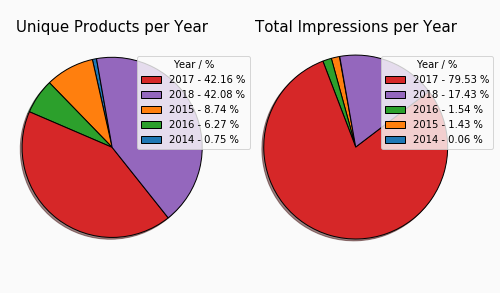

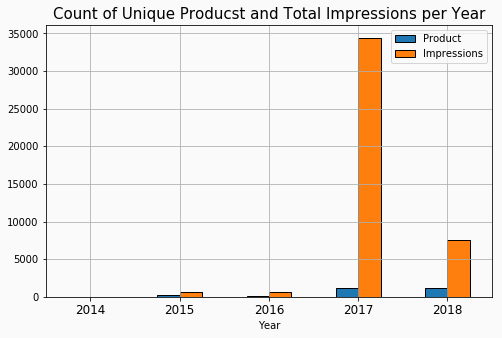

In [17]:
#Setting background color for all graphs
bg_color = (0.98,0.98,0.98)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

#Create impressions pie chart data frame
pie_prod = df.groupby('year').agg({'name':'nunique','Date_imp':'count'}).reset_index()
pie_prod = pie_prod.rename(columns = {'year':'Year','name':'Product', 'Date_imp':'Impressions'})
x = pie_prod['Year']
unique_prod = pie_prod['Product']
Imp_count = pie_prod['Impressions']
percent_unique = 100.*unique_prod/unique_prod.sum()
percent_imp = 100.*Imp_count/Imp_count.sum()


#Pie Chart subplots 
plt.rcParams['figure.figsize'] = [8, 5]
plt.subplot(121)
patches, texts = plt.pie(unique_prod  ,startangle=100, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': 1, 'antialiased': True})
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent_unique)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, unique_prod),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.legend(patches, labels, loc='upper center', title = 'Year / %', bbox_to_anchor = (.9, .85),
           fontsize = 10)
    
plt.title('Unique Products per Year',fontsize = 15, y=.9)
plt.axis('equal')

plt.subplot(122)
patches, texts = plt.pie(Imp_count , startangle=100, shadow = True, wedgeprops={"edgecolor":"k",'linewidth': 1, 'antialiased': True})
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent_imp)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, Imp_count),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.legend(patches, labels, loc='upper center', title = 'Year / %', bbox_to_anchor = (.9, .85),
           fontsize = 10)
plt.title('Total Impressions per Year',fontsize = 15, y=.9)
plt.axis('equal')
plt.show()


pie_prod.plot.bar(x ='Year', rot=0, grid = True, edgecolor='k')
plt.title('Count of Unique Producst and Total Impressions per Year', fontsize=15)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=10)
plt.show()

In previous charts, we can vizualize that about 80% of the impressions in the dataset ocurred in 2017. For this main reason our analysis would cover only year 2017

In [18]:
#Select only 2017 Impressions for analysis
df = df[df['year'] == 2017]
print("New DataFrame Dimensions with only 2017 Impressions:",len(df))

New DataFrame Dimensions with only 2017 Impressions: 34389


In [19]:
#Add Discount percentage of products with impressions
df['Disc_percentage']= round(1-(df['disc_price']/df['price']),2)

In [20]:

# gives some infomation on columns types and number of null values and unique values 
summary_tab = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
summary_tab= summary_tab.append(pd.DataFrame(df.nunique()).T.rename(index={0:'Unique Values'}))
summary_tab= summary_tab.append(pd.DataFrame(df.count()).T.rename(index={0:'Total Count'}))
summary_tab= summary_tab.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
summary_tab = summary_tab.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values, unique values and total count" + '-' * 10 )
print 
display(summary_tab)

---------- Display information about column types and number of null values, unique values and total count----------


,Imp_count,brand,condition,currency,dateAdded,dateSeen,dateUpdated,disc_price,imageURLs,isSale,manufacturer,merchant,name,p_description,price,shipping,sourceURLs,weight,Date_imp,Date_imp_d,Day_n,year,month,month_n,day,Week_Number,Disc_percentage
column type,int64,object,object,object,object,object,object,float64,object,object,object,object,object,object,float64,object,object,object,datetime64[ns],object,object,int64,int64,object,int64,int64,float64
Unique Values,54,296,5,5,1077,5785,983,3697,1142,2,266,13,1129,1118,3546,131,6415,748,2217,270,7,1,12,12,31,51,74
Total Count,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389,18638,34389,34389,34389,34389,16111,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389,34389
null values (nb),0,0,0,0,0,0,0,0,0,0,15751,0,0,0,0,18278,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,45.8024,0,0,0,0,53.1507,0,0,0,0,0,0,0,0,0,0,0
